# Get the data:

This data and project is associated with https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb

Thanks! to **Aurelien Geron**.

In [4]:
from pathlib import Path
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

# Importing necessary libraries.

In [3]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import FunctionTransformer

# Exploring the data.

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.shape

(20640, 10)

Data has **20640** rows and **10** columns.

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**total_bedrooms      20433 non-null  float64**

We need to take it into account. It means 207 values are missing from that.

**ocean_proximity** is a non-numeric column.

In [8]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let's take a look at summary.

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Quick view of data distribution.

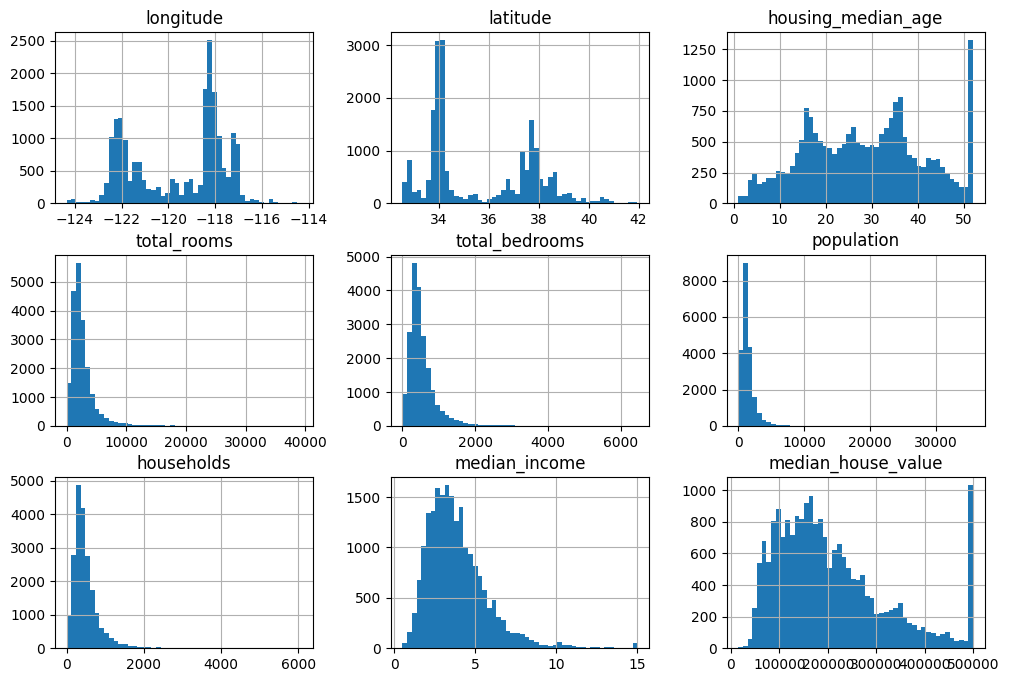

In [10]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

**Key findings from histograms:**

- **median_income** doesnt look expressed in dollars. More over it is scaled and capped at 15
(actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes.
   - 3 means 30,000 but it's not a problem, the thing is that we need to understand that.
- The housing **median_age** and the **median_house** value were also
capped. The latter may be a serious problem since it is our target
attribute (your labels). Our machine learning algorithms may learn
that prices never go beyond that limit.
    - Remove those districts from the training set (and also from the
test set, since your system should not be evaluated poorly if it
predicts values beyond $500,000).
- Finally, many histograms are skewed right: they extend much farther to
the right of the median than to the left. This may make it a bit harder
for some machine learning algorithms to detect patterns. Later, we’ll
try transforming these attributes to have more symmetrical and bellshaped
distributions.

# Creating test set.
There are different ways we can make a test set.

- Using **train_test_split** from sklearn.
    -  This is
generally fine if your dataset is large enough (especially relative to the
number of attributes), but if it is not, you run the risk of introducing a
significant sampling bias.
- Using **StratifiedShuffleSplit**, available in sklearn.
- Making a shuffle function using numpy ❌




In [11]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

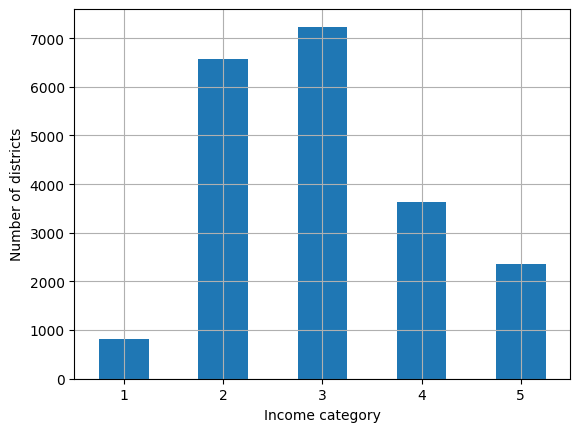

In [12]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [13]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

We won’t use the income_cat column again, so you might as well drop
it, reverting the data back to its original state

In [14]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

# Explore and Visualize the Data to Gain Insights

So far we have only taken a quick glance at the data to get a general
understanding of the kind of data you are manipulating. Now the goal is to
go into a little more depth.

In [15]:
# Making a copy of training set, because we will experiment with transformations etc.
housing = strat_train_set.copy()

### Geographical data.

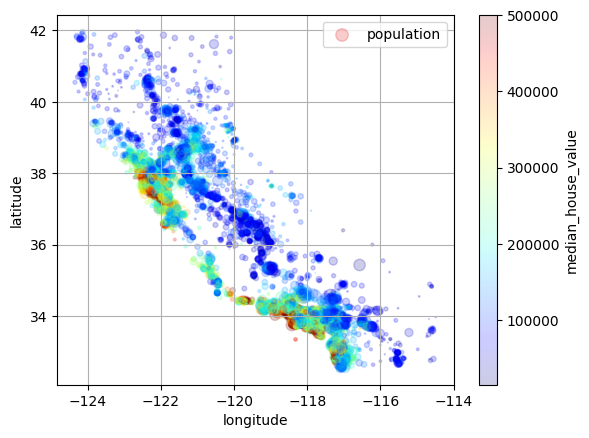

In [16]:
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.2,
    s=housing['population']/100,
    label='population',
    c='median_house_value',
    cmap='jet',
    colorbar=True,
    legend=True,
    grid=True
)
plt.show()

California housing prices: red is expensive, blue is cheap, larger circles indicate areas
with a larger population

### Look for correlations.

In [17]:
corr_matrix = housing.corr()

<ipython-input-17-bac487469033>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [18]:
housing.shape

(16512, 10)

10^2 = 100 means if we draw corr graphs for all there will be 100 graphs. So, we will be checking correlation of attributes which would be more correlated.

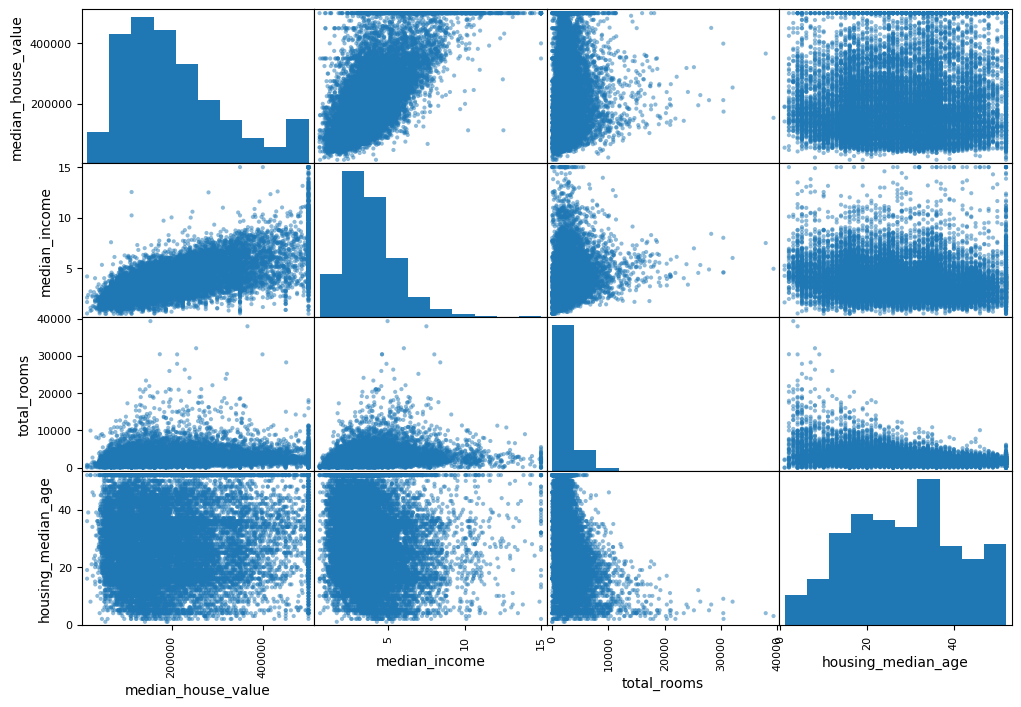

In [19]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

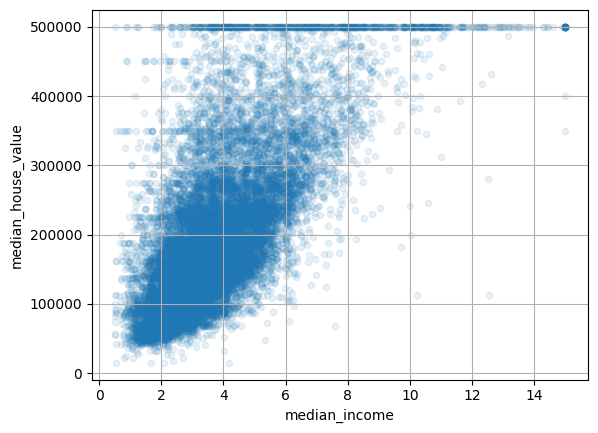

In [20]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

This plot reveals a few things. First, the correlation is indeed quite strong;
you can clearly see the upward trend, and the points are not too dispersed.
Second, the price cap you noticed earlier is clearly visible as a horizontal
line at 500,000. But the plot also reveals other less obvious straight lines: a
horizontal line around 450,000, another around 350,000, perhaps one
around 280,000, and a few more below that. We may want to try
removing the corresponding districts to prevent our algorithms from
learning to reproduce these data quirks.

### Experimenting with attributes.

One last thing we may want to do before preparing the data for machine
learning algorithms is to try out various attribute combinations.
For example, the total number of rooms in a district is not very useful if we
don’t know how many households there are. What you really want is the
number of rooms per household.

In [21]:
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']


In [22]:
corr_matrix = housing.corr()

<ipython-input-22-bac487469033>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [23]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

Well, bedrooms_ratio is much more correlated then total_rooms. From this correlation we can conclude that house with less rooms tends to be more expensive.

The number of rooms per household is also more
informative than the total number of rooms in a district—obviously the
larger the houses, the more expensive they are.


--------
This round of exploration does not have to be absolutely thorough; the point
is to start off on the right foot and quickly gain insights that will help you
get a first reasonably good prototype. But this is an iterative process: once
you get a prototype up and running, you can analyze its output to gain more
insights and come back to this exploration step.

---------

# Prepare the Data for Machine Learning Algorithms



### Seprating ***labels*** and ***predictors***.

In [24]:
# Predictor.
housing = strat_train_set.drop("median_house_value", axis=1)

# Labels.
housing_labels = strat_train_set['median_house_value'].copy()

In [25]:
housing_labels.head()

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
Name: median_house_value, dtype: float64

In [26]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN


### Clean data

***Getting ride from missing data:***

Methods:

1. Get rid of the corresponding districts.
2. Get rid of the whole attribute.
3. Set the missing values to some value (zero, the mean, the median,
etc.). This is called imputation.
4. KNNImputer
5. IterativeImputer


In [27]:
imputer = SimpleImputer(strategy='median')

# Selecting the numeric data.
housing_num = housing.select_dtypes(include=[np.number])

# Fitting the imputer.
imputer.fit(housing_num)

# Transforming the data.
X = imputer.transform(housing_num)

In [28]:
# Transformed data:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [29]:
housing_tr.isna().sum().sort_values(ascending=False)

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

### Handling categorical data.

There is only one categorycal attribute ***oceam_proximity***.

Seprating categorical data.

In [30]:
housing_cat = housing[['ocean_proximity']]

In [31]:
housing_cat.head()

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN


***Using OneHotEncoder:***

The advantage of OneHotEncoder is that it remembers which
categories it was trained on. This is very important because once your
model is in production, it should be fed exactly the same features as during
training: no more, no less.


In [32]:
# Instantiating encoder.
cat_encoder = OneHotEncoder(sparse=False) # sparse argument for handling sparse matrix.

# Fitting and tranforming encoder.
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [33]:
# Chacking the encoded data.
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [34]:
# Categories involved: confrming that there is no issue.
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Feature scaling and transformation.

- Scaling is required when we use any ML algorithm that requires gradient calculation e.g. Linear/Logistic Regression and ANN.
- Having different scales for each feature will result in a different step size which in turn jeopardize the process of reaching minimum point.
- Scaling isn't required for distance based and tree based algorithms such as K-Means Clustring, SVM, KNN Decision Trees, Random Forest, and XGBoost.

- ***MinMaxscaler / Normalization***

    - Normalize Values between 0 to 1.
    - Preferred in case of neural networks, since we don't assume any data distribution.

- ***StandardScalar / Standardization***

    - Normalize values between mean 0 and standard deviation 1, but value may be any.
    - Best when we have lot of outliers in our data.
    - It is preferred when data follows gaussian distribution.

When a feature’s distribution has a heavy tail (i.e., when values far from the mean are not exponentially rare), both min-max scaling and standardization
will squash most values into a small range. Machine learning models
generally don’t like this at alL.

*So before you
scale the feature, you should first transform it to shrink the heavy tail, and if
possible to make the distribution roughly symmetrical.*

***Common ways to do that:***

- A
common way to do this for positive features with a heavy tail to the right is
to replace the feature with its square root (or raise the feature to a power
between 0 and 1).

- If the feature has a really long and heavy tail, such as a *power law distribution*, then replacing the feature with its logarithm may
help.

- For multimodal distribution, handling heavy-tailed features consists in bucketizing the
feature. This means chopping its distribution into roughly equal-sized
buckets, and replacing each feature value with the index of the bucket it
belongs to.

- Another approach to transforming multimodal distributions is to add a
feature for each of the modes (at least the main ones), representing the
similarity between the housing median age and that particular mode.
    - The
similarity measure is typically computed using a radial basis function
(RBF)---any function that depends only on the distance between the input
value and a fixed point.

----
The target values may
also need to be transformed.

For example, if the target distribution has a
heavy tail, we may choose to replace the target with its logarithm. But if
we do, the regression model will now predict the log of the median house
value, not the median house value itself. we will need to compute the
exponential of the model’s prediction if we want the predicted median
house value.
- Scikit-Learn’s transformers have an *inverse_transform()* method, making it easy to compute the inverse
of their transformations.

- A simpler option is to use a *TransformedTargetRegressor*.

The difference in both of them is that in case of *inverse_transform()*, first we need to predict values then take its inverse. But in second case of *TransformedTargetRegressor* we just need to instantiate, fit and predict.
    


**An example of standard scalar and TransformedTargetRegressor:**
```
from sklearn.compose import TransformedTargetRegressor
model = TransformedTargetRegressor(LinearRegression(),
        transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)
```



## Custom Transformers
Although Scikit-Learn provides many useful transformers, we will need to
write your own for tasks such as custom transformations, cleanup
operations, or combining specific attributes.


Let’s create a log-transformer and apply it to the population
feature:

In [35]:
# taking log of population.
log_transformer = FunctionTransformer(
    np.log,
    inverse_func=np.exp # optional, just if to take inverse.
)
log_pop = log_transformer.transform(housing[["population"]])

In [36]:
rbf_transformer = FunctionTransformer(
    rbf_kernel,
    kw_args=dict(Y=[[35]], gamma=0.1)
)

age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

There’s no inverse function for the RBF kernel, since there are
always two values at a given distance from a fixed point (except at distance
0). Also note that rbf_kernel() does not treat the features separately. If
you pass it an array with two features, it will measure the 2D distance
(Euclidean) to measure similarity.

Custom transformers are also useful to combine features.

For example,
here’s a FunctionTransformer that computes the ratio between the
input features 0 and 1:
```
>>> ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] /
X[:, [1]])
>>> ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))
array([[0.5 ],
[0.75]])
```

FunctionTransformer is very handy, but what if we would like your
transformer to be trainable, learning some parameters in the fit() method
and using them later in the transform() method? For this, we need to
write a custom class. Scikit-Learn relies on duck typing, so this class does
not have to inherit from any particular base class. All it needs is three
methods: fit() (which must return self), transform(), and
fit_transform().

We can get fit_transform() for free by simply adding
TransformerMixin as a base class: the default implementation will just
call fit() and then transform(). If we add BaseEstimator as a
base class (and avoid using *args and **kwargs in your constructor),
we will also get two extra methods: get_params() and
set_params(). These will be useful for automatic hyperparameter
tuning.

------------------------

A custom transformer can (and often does) use other estimators in its
implementation. For example, the following code demonstrates custom
transformer that uses a KMeans clusterer in the fit() method to identify
the main clusters in the training data, and then uses rbf_kernel() in the
transform() method to measure how similar each sample is to each
cluster center:

```
from sklearn.cluster import KMeans
class ClusterSimilarity(BaseEstimator, TransformerMixin):
def __init__(self, n_clusters=10, gamma=1.0,
random_state=None):
self.n_clusters = n_clusters
self.gamma = gamma
self.random_state = random_state
def fit(self, X, y=None, sample_weight=None):
self.kmeans_ = KMeans(self.n_clusters,
random_state=self.random_state)
self.kmeans_.fit(X, sample_weight=sample_weight)
return self # always return self!
def transform(self, X):
return rbf_kernel(X, self.kmeans_.cluster_centers_,
gamma=self.gamma)
def get_feature_names_out(self, names=None):
return [f"Cluster {i} similarity" for i in
range(self.n_clusters)]
```

In [37]:
from sklearn.cluster import KMeans
from sklearn.base import TransformerMixin, BaseEstimator
class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0,
  random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state
  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters,
    random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self # always return self!
  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_,
    gamma=self.gamma)
  def get_feature_names_out(self, names=None):
    return [f"Cluster {i} similarity" for i in
    range(self.n_clusters)]

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.,
random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)
similarities[:3].round(2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

In [ ]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

# Transformation Pipelines

There are many data transformation steps that need to be
executed in the right order. Fortunately, Scikit-Learn provides the
Pipeline class to help with such sequences of transformations. Here is a
small pipeline for numerical attributes, which will first impute then scale
the input features:

## Pipeline

The Pipeline constructor takes a list of name/estimator pairs (2-tuples)
defining a sequence of steps. The names can be anything you like, as long
as they are unique and don’t contain double underscores (__). They will be
useful later, when we discuss hyperparameter tuning. The estimators must
all be transformers (i.e., they must have a fit_transform() method),
except for the last one, which can be anything: a transformer, a predictor, or
any other type of estimator.

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline  import Pipeline

# Instantiating pipeline.
num_pipeline = Pipeline(
    [
        ("impute", SimpleImputer(strategy='median')),
        ("standardize", StandardScaler())
    ]
)


## make_pipeline

If we don’t want to name the transformers, you can use the
make_pipeline() function instead; it takes transformers as positional
arguments and creates a Pipeline using the names of the transformers’
classes, in lowercase and without underscores (e.g., "simpleimputer"):

If multiple transformers have the same name, an index is appended to their
names (e.g., "foo-1", "foo-2", etc.).

When you call the pipeline’s fit() method, it calls fit_transform()
sequentially on all the transformers, passing the output of each call as the
parameter to the next call until it reaches the final estimator, for which it
just calls the fit() method.
The pipeline exposes the same methods as the final estimator.

In [39]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                              StandardScaler()
      )

In [40]:
# Fitting the pipeline.
husing_num_prepared = num_pipeline.fit_transform(housing_num)
husing_num_prepared[:2]

array([[-1.42303652,  1.0136059 ,  1.86111875,  0.31191221,  1.36816703,
         0.13746004,  1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, -0.30861991, -0.43592476,
        -0.69377062, -0.37348471,  1.17194198]])

In [42]:
# If we want a dataframe.

df_housing_num_prepared = pd.DataFrame(
    husing_num_prepared,
    columns = num_pipeline.get_feature_names_out(),
    index = housing_num.index
)

df_housing_num_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365


Pipelines support indexing; for example, pipeline[1] returns the
second estimator in the pipeline, and pipeline[:-1] returns a
Pipeline object containing all but the last estimator. You can also access
the estimators via the steps attribute, which is a list of name/estimator
pairs, or via the named_steps dictionary attribute, which maps the
names to the estimators. For example,
num_pipeline["simpleimputer"] returns the estimator named
"simpleimputer".

In [43]:
num_pipeline[:]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

## ColumnTransformer

It would be more convenient to have a single transformer
capable of handling all columns, applying the appropriate transformations
to each column. For this, you can use a ColumnTransformer. For
example, the following ColumnTransformer will apply
num_pipeline (the one we just defined) to the numerical attributes and
cat_pipeline to the categorical attribute:

In [44]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age",
                "total_rooms",
                "total_bedrooms", "population", "households",
                "median_income"]
cat_attribs = ["ocean_proximity"]
cat_pipeline = make_pipeline(
                SimpleImputer(strategy="most_frequent"),
                OneHotEncoder(handle_unknown="ignore")
                )
preprocessing = ColumnTransformer([
                  ("num", num_pipeline, num_attribs),
                  ("cat", cat_pipeline, cat_attribs),
])

Its not convenient to select all columns by names thats why sklearn provides such functionality to select columns by names.

In [45]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

housing_prepared = preprocessing.fit_transform(housing)

In [46]:
def column_ratio(X):
  return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_name_in):
  return ["ratio"] # feature names out.

def ratio_pipeline():
  return make_pipeline(
      SimpleImputer(strategy="median"),
      FunctionTransformer(
          column_ratio,
          feature_names_out=ratio_name
      ),
      StandardScaler()
  )

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(
        np.log, feature_names_out="one-to-one"
    ),
    StandardScaler()
)


clusture_simil = ClusterSimilarity(
    n_clusters=10,
    gamma=1.,
    random_state=42
)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

preprocessing = ColumnTransformer(
    [
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ['total_rooms', "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object))
    ],
    remainder=default_num_pipeline  # one column remaining: housing_median_age
)




In [47]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(16512, 24)

In [48]:
preprocessing.get_feature_names_out

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x79c25bfebac0>,
                                                                      func=<function column_ratio...
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['population', 'households']),
                                ('geo', ClusterSimilarity(random_state=42),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x79c25c1a2c50>)])>

# Select and Train a Model

## Train and evaluate on the Training Set

In [49]:
import sklearn
sklearn.set_config(display="diagram") # shows diagram when pipeline called see below.

In [50]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(
    preprocessing,
    LinearRegression()
)

lin_reg.fit(housing, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x79c...
                                                  ['population', 'households']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x79c25c1a2c50>)])),
                ('linearregression', LinearRegression())])

In [51]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

array([243700., 372400., 128800.,  94400., 328300.])

In [52]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

**Evaluation**

In [53]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(
    housing_labels,
    housing_predictions,
    squared=False
)

In [54]:
lin_rmse

68687.89176590036

This is better than nothing, but clearly not a great score: the
median_housing_values of most districts range between 120,000
and 265,000, so a typical prediction error of 68,628 is really not very
satisfying. This is an example of a model **underfitting** the training data.

In [55]:
housing_labels.describe()

count     16512.000000
mean     206333.518653
std      115314.047529
min       14999.000000
25%      119200.000000
50%      179200.000000
75%      263925.000000
max      500001.000000
Name: median_house_value, dtype: float64

Personal Note: I still didnt tried Isolation forest to remove outliers, and Geron also didnt lets se what happens.

**Decision Tree Regressor**

In [56]:
# Importing.
from sklearn.tree import DecisionTreeRegressor

# Instantiating.
tree_reg = make_pipeline(
    preprocessing,
    DecisionTreeRegressor(random_state =42)
)

# Fitting.
tree_reg.fit(housing, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x79c...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x79c25c1a2c50>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [57]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)

In [ ]:
housing_predictions[:5]

In [59]:
tree_rmse

0.0

Wait, what!? No error at all? Could this model really be absolutely perfect?
Of course, **it is much more likely that the model has badly overfit the data.**
How can you be sure? As we saw earlier, we don’t want to touch the test
set until we are ready to launch a model we are confident about, so we
need to use part of the training set for training and part of it for model
validation.

## Better Evaluation Using Cross-Validation
**k-fold cross-validation.**

In [60]:
from sklearn.model_selection import cross_val_score

tree_rmse = cross_val_score(
    tree_reg, # DecisionTreeRegressor instance.
    housing,
    housing_labels,
    scoring="neg_root_mean_squared_error",
    cv=10 # k
)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [61]:
pd.Series(tree_rmse).describe()

count       10.000000
mean    -66723.687561
std       2224.917827
min     -70495.483248
25%     -68131.509944
50%     -66161.313206
75%     -64830.289458
max     -64171.648665
dtype: float64

Now the decision tree doesn’t look as good as it did earlier. In fact, it seems
to perform almost as poorly as the linear regression model

## RandomForest

Random forests work by training many decision trees
on random subsets of the features, then averaging out their predictions.
Such models composed of many other models are called ensembles: they
are capable of boosting the performance of the underlying model (in this
case, decision trees)

In [62]:
from sklearn.ensemble import RandomForestRegressor

In [63]:
forest_reg = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42)
)

forest_rmse = cross_val_score(
    forest_reg,
    housing,
    housing_labels,
    scoring="neg_root_mean_squared_error",
    cv=10
)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [64]:

pd.Series(forest_rmse).describe()

count       10.000000
mean    -47025.806913
std       1024.062564
min     -49286.427305
25%     -47303.499024
50%     -46923.591101
75%     -46611.026676
max     -45406.817551
dtype: float64

Much better but, still overfitt.

# Fine-Tune your model

# TODO:
Lets assume we have a promising model.

## Grid Search


In [65]:
from sklearn.model_selection import GridSearchCV

# setting pipeline.
full_pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("random_forest", RandomForestRegressor(random_state=42))
    ]
)

# Possible params.
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
    'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
    'random_forest__max_features': [6, 8, 10]}
]

# instantiating GridSearch.
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                                  scoring='neg_root_mean_squared_error')
# Fitting GridSearch.
grid_search.fit(housing, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x79c25c1a2c50>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [66]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [71]:
# Evaluation scores.
cv_res = pd.DataFrame(grid_search.cv_results_)

cv_res.sort_values(by="mean_test_score", ascending=False,
inplace=True)

cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,4.676423,0.208178,0.119525,0.001433,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43376.371960,-43806.638762,-44769.068961,-43984.026561,582.237670,1
13,5.971688,0.106577,0.122206,0.000900,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-43979.330055,-44067.348898,-45166.516971,-44404.398641,540.095726,2
14,6.897589,0.125160,0.128231,0.005553,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-44237.967707,-44493.052868,-45392.406281,-44707.808952,495.158047,3
7,6.490848,0.647192,0.165143,0.046808,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44700.475490,-44741.008895,-45808.918710,-45083.467698,513.238162,4
9,4.641945,0.131809,0.134097,0.015487,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44700.475490,-44741.008895,-45808.918710,-45083.467698,513.238162,4


## Randomized Search:

In [72]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [73]:
param_distribs = {'preprocessing__geo__n_clusters':
                    randint(low=3, high=50),
                    'random_forest__max_features': randint(low=2,
                    high=20)}
rnd_search = RandomizedSearchCV(
                                  full_pipeline,
                                  param_distributions=param_distribs,
                                  n_iter=10,
                                  cv=3,
                                  scoring='neg_root_mean_squared_error',
                                  random_state=42)
rnd_search.fit(housing, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79c25b9a4610>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79c25b9a4e20>},
                   random_state=42, scoring='neg_root_mean_squared_error')

### Analyzing the Best Models and Their Errors

In [75]:
rnd_search.best_params_

{'preprocessing__geo__n_clusters': 45, 'random_forest__max_features': 9}

In [74]:
# Evaluation scores.
cv_res = pd.DataFrame(rnd_search.cv_results_)

cv_res.sort_values(by="mean_test_score", ascending=False,
inplace=True)

cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,6.929805,0.413859,0.141354,0.005618,45,9,"{'preprocessing__geo__n_clusters': 45, 'random...",-41351.045020,-42151.249292,-42849.482543,-42117.258952,612.206533,1
8,5.739244,0.292688,0.153153,0.019592,32,7,"{'preprocessing__geo__n_clusters': 32, 'random...",-41428.058098,-42335.194433,-43120.174539,-42294.475690,691.403415,2
0,11.818901,1.287498,0.139600,0.003317,41,16,"{'preprocessing__geo__n_clusters': 41, 'random...",-42168.090123,-42984.733808,-43378.551993,-42843.791975,504.118330,3
5,3.928508,0.132185,0.136667,0.002308,42,4,"{'preprocessing__geo__n_clusters': 42, 'random...",-41847.338550,-42888.381984,-43892.688402,-42876.136312,835.055476,4
2,5.914370,0.226209,0.121249,0.001143,23,8,"{'preprocessing__geo__n_clusters': 23, 'random...",-42483.923510,-43121.892587,-43890.100512,-43165.305536,574.889528,5


In [77]:
final_model = rnd_search.best_estimator_

feature_importances = final_model["random_forest"].feature_importances_

feature_importances.round(2)

array([0.06, 0.06, 0.01, 0.01, 0.01, 0.01, 0.2 , 0.05, 0.04, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.  , 0.01, 0.01, 0.01, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.02, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.02, 0.01, 0.02, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [78]:
sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(0.20278940069371176, 'log__median_income'),
 (0.07220211824586319, 'cat__ocean_proximity_INLAND'),
 (0.05822382081192795, 'bedrooms__ratio'),
 (0.055087317550791236, 'rooms_per_house__ratio'),
 (0.05017667616983935, 'people_per_house__ratio'),
 (0.03553871481900168, 'geo__Cluster 0 similarity'),
 (0.029299387397032924, 'geo__Cluster 28 similarity'),
 (0.02452326599232423, 'geo__Cluster 24 similarity'),
 (0.022215109946404757, 'geo__Cluster 34 similarity'),
 (0.018659412880146706, 'geo__Cluster 27 similarity'),
 (0.017828867639541248, 'geo__Cluster 43 similarity'),
 (0.016154626788538674, 'geo__Cluster 37 similarity'),
 (0.01581343529874524, 'geo__Cluster 39 similarity'),
 (0.015571803331429166, 'geo__Cluster 20 similarity'),
 (0.014743977984222055, 'geo__Cluster 31 similarity'),
 (0.014365311213212661, 'geo__Cluster 7 similarity'),
 (0.012860767817770258, 'geo__Cluster 9 similarity'),
 (0.012574136559443734, 'geo__Cluster 40 similarity'),
 (0.01224474978123244, 'remainder__housing_me

## Ensemble Methods

Another way to fine-tune your system is to try to combine the models that
perform best. The group (or “ensemble”) will often perform better than the
best individual model—just like random forests perform better than the
individual decision trees they rely on—especially if the individual models
make very different types of errors.

## Evaluate Your System on the Test Set

With this information, we may want to try dropping some of the less useful
features (e.g., apparently only one ocean_proximity category is really
useful, so you could try dropping the others).

The sklearn.feature_selection.SelectFromModel transformer can
automatically drop the least useful features for you: when you fit it, it trains a model
(typically a random forest), looks at its feature_importances_ attribute, and
selects the most useful features. Then when you call transform(), it drops the other
features.

You should also look at the specific errors that your system makes, then try
to understand why it makes them and what could fix the problem: adding
extra features or getting rid of uninformative ones, cleaning up outliers, etc.

Now is also a good time to ensure that your model not only works well on
average, but also on all categories of districts, whether they’re rural or
urban, rich or poor, northern or southern, minority or not, etc.

In [79]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
final_predictions = final_model.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions,
squared=False)
print(final_rmse)

41521.43752659845


In [80]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
loc=squared_errors.mean(),
scale=stats.sem(squared_errors)))

array([39345.00770773, 43589.33260592])